In [ ]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import gcsfs

In [2]:
# refer: 
# https://github.com/ycheng30/Expedia-Hotel-Recommendation-Kaggle
# https://medium.com/@wesleyklock/expedia-hotel-recommendations-ea6a9d5fbaa7



dataUri = "gs://bigdata-proj/train.csv"
trainUri = "gs://bigdata-proj/expedia-hotel-recommendations_train_train.csv"
testUri = "gs://bigdata-proj/expedia-hotel-recommendations_train_test.csv"
resultUri = "gs://bigdata-proj/expedia-hotel-recommendations_predict"

dtype={'is_booking':bool,
        'srch_ci' : np.str_,
        'srch_co' : np.str_,
        'srch_adults_cnt' : np.int32,
        'srch_children_cnt' : np.int32,
        'srch_rm_cnt' : np.int32,
        'srch_destination_id':np.str_,
        'user_location_country' : np.str_,
        'user_location_region' : np.str_,
        'user_location_city' : np.str_,
        'hotel_cluster' : np.str_,
        'orig_destination_distance':np.float64,
        'date_time':np.str_,
        'hotel_market':np.str_}

In [ ]:
df = pd.read_csv(trainUri, dtype=dtype, usecols=dtype, parse_dates=['date_time'] ,sep=',')
df['year']=df['date_time'].dt.year
train = df.query('is_booking==True')
del df
df1 = pd.read_csv(testUri, dtype=dtype, usecols=dtype, parse_dates=['date_time'] ,sep=',')
df1['year']=df1['date_time'].dt.year
test = df1.query('is_booking==True')
del df1

In [4]:
train['srch_ci']=pd.to_datetime(train['srch_ci'],infer_datetime_format = True,errors='coerce')
train['srch_co']=pd.to_datetime(train['srch_co'],infer_datetime_format = True,errors='coerce')

train['month']= train['date_time'].dt.month
train['plan_time'] = ((train['srch_ci']-train['date_time'])/np.timedelta64(1,'D')).astype(float)
train['hotel_nights']=((train['srch_co']-train['srch_ci'])/np.timedelta64(1,'D')).astype(float)

In [6]:
test['srch_ci']=pd.to_datetime(test['srch_ci'],infer_datetime_format = True,errors='coerce')
test['srch_co']=pd.to_datetime(test['srch_co'],infer_datetime_format = True,errors='coerce')

test['month']= test['date_time'].dt.month
test['plan_time'] = ((test['srch_ci']-test['date_time'])/np.timedelta64(1,'D')).astype(float)
test['hotel_nights']=((test['srch_co']-test['srch_ci'])/np.timedelta64(1,'D')).astype(float)

In [7]:
mean_val=train.orig_destination_distance.mean()
train['orig_destination_distance']=train.orig_destination_distance.fillna(mean_val)
train.fillna(-1,inplace=True)
lst_drop=['date_time','srch_ci','srch_co']
train.drop(lst_drop,axis=1,inplace=True)

mean_val=test.orig_destination_distance.mean()
test['orig_destination_distance']=test.orig_destination_distance.fillna(mean_val)
test.fillna(-1,inplace=True)
lst_drop=['date_time','srch_ci','srch_co']
test.drop(lst_drop,axis=1,inplace=True)

In [8]:
y_train=train['hotel_cluster']
x_train=train.drop(['hotel_cluster','is_booking','year'],axis=1)
del train
y_test=test['hotel_cluster']
x_test=test.drop(['hotel_cluster','is_booking','year'],axis=1)
del test

In [ ]:
tree = RandomForestClassifier(n_estimators=31,max_depth=10,random_state=123)
tree.fit(x_train,y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=31,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

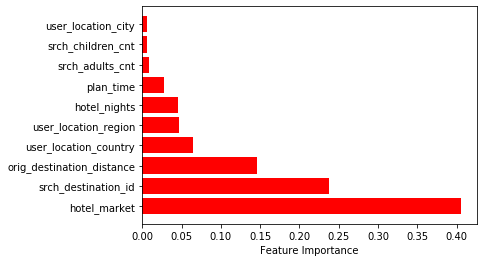

In [11]:
importance_rank = tree.feature_importances_
indices=np.argsort(importance_rank)[::-1][:10]
plt.barh(range(10), importance_rank[indices],color='r')
plt.yticks(range(10),x_train.columns[indices])
plt.xlabel('Feature Importance')
plt.show()

In [14]:
dict_cluster = {}
for (k,v) in enumerate(tree.classes_):
    dict_cluster[k] = v

y_pred=tree.predict_proba(x_test)
#take largest 5 probablities' indexes
raw_pred=y_pred.argsort(axis=1)[:,-5:]

In [15]:
pred = []
for i in raw_pred.flatten():
    pred.append(dict_cluster.get(i))
cluster_pred = np.array(pred).reshape(raw_pred.shape)    


[['59' '48' '95' '18' '91']
 ['16' '28' '42' '48' '91']
 ['39' '28' '42' '48' '91']
 ...
 ['41' '98' '1' '95' '91']
 ['64' '91' '59' '26' '0']
 ['81' '46' '62' '36' '64']]
0          18
1           4
34          9
36          1
51         43
           ..
9417533    72
9417560    22
9417563     9
9417564    26
9417567    58
Name: hotel_cluster, Length: 749964, dtype: object


In [40]:
correctness = 0
for target, pred in zip(y_test, cluster_pred):
    if target in pred:
        correctness += 1
print(correctness)
print(correctness / len(y_test))

259725
0.3463166231979135


0          18
1           4
34          9
36          1
51         43
           ..
9417533    72
9417560    22
9417563     9
9417564    26
9417567    58
Name: hotel_cluster, Length: 749964, dtype: object